In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [108]:
dir_list = {
    0: '../data/Trends Smart City/0EG/',
    1: '../data/Trends Smart City/1OG/',
    2: '../data/Trends Smart City/2OG/',
    3: '../data/Trends Smart City/3OG/'
}
file_list = {
    0: os.listdir(dir_list[0]),
    1: os.listdir(dir_list[1]),
    2: os.listdir(dir_list[2]),
    3: os.listdir(dir_list[3])
}

In [99]:
rooms_temp = []
names_temp = []
rooms_qual = []
names_qual = []

for floor in dir_list.keys():
    for file in file_list[floor]:
        room_df = pd.read_csv(
            dir_list[floor] + file,
            sep=';',
            parse_dates=True,
            header=0,
            index_col=0,
            names=[file.split()[0], '_1', '_2', '_3'],
            )
        room_df.index.name = 'Time'
        if file.split()[1][:-4] == 'Lufttemp':
            names_temp.append(file.split()[0])
            rooms_temp.append(room_df.iloc[:,0].dropna().tolist())
        else:
            names_qual.append(file.split()[0])
            rooms_qual.append(room_df.iloc[:,0].dropna().tolist())

In [134]:
rooms_data = [rooms_temp, rooms_qual]
names_list = [names_temp, names_qual]
titles = ["Temperatur", "Luftqualität"]
axes = ['Temperatur (°C)', 'CO2 (ppm)']

# Histogram

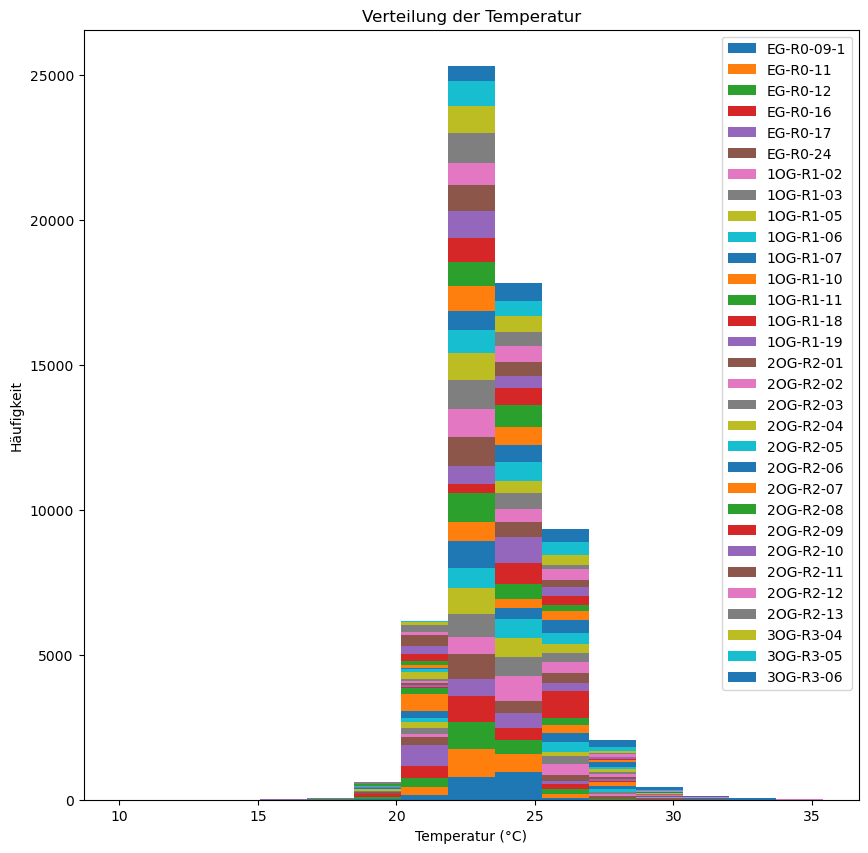

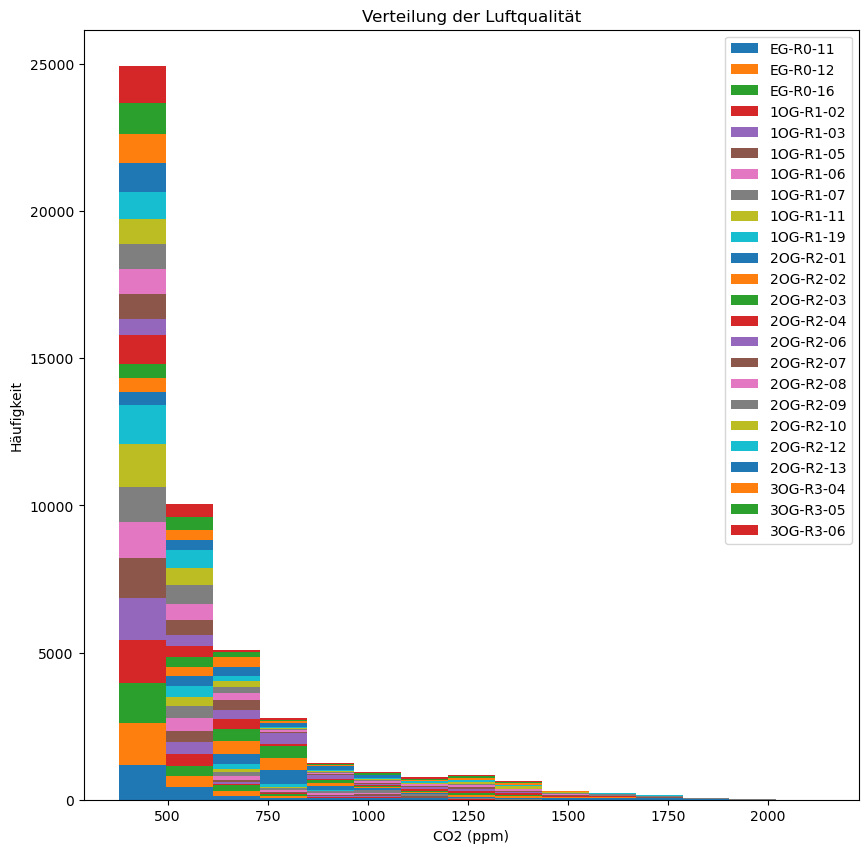

In [138]:
# Single Histogram

for room, name, title, xaxis in zip(rooms_data, names_list, titles, axes):
    plt.figure(figsize=(10, 10))
    plt.hist(room, bins=15, stacked=True, label=name)
    plt.legend()
    plt.title("Verteilung der " + title)
    plt.xlabel(xaxis)
    plt.ylabel("Häufigkeit")

    plt.savefig("../plots/distribution_plots/Histogram " + title + ".png")
    plt.show()

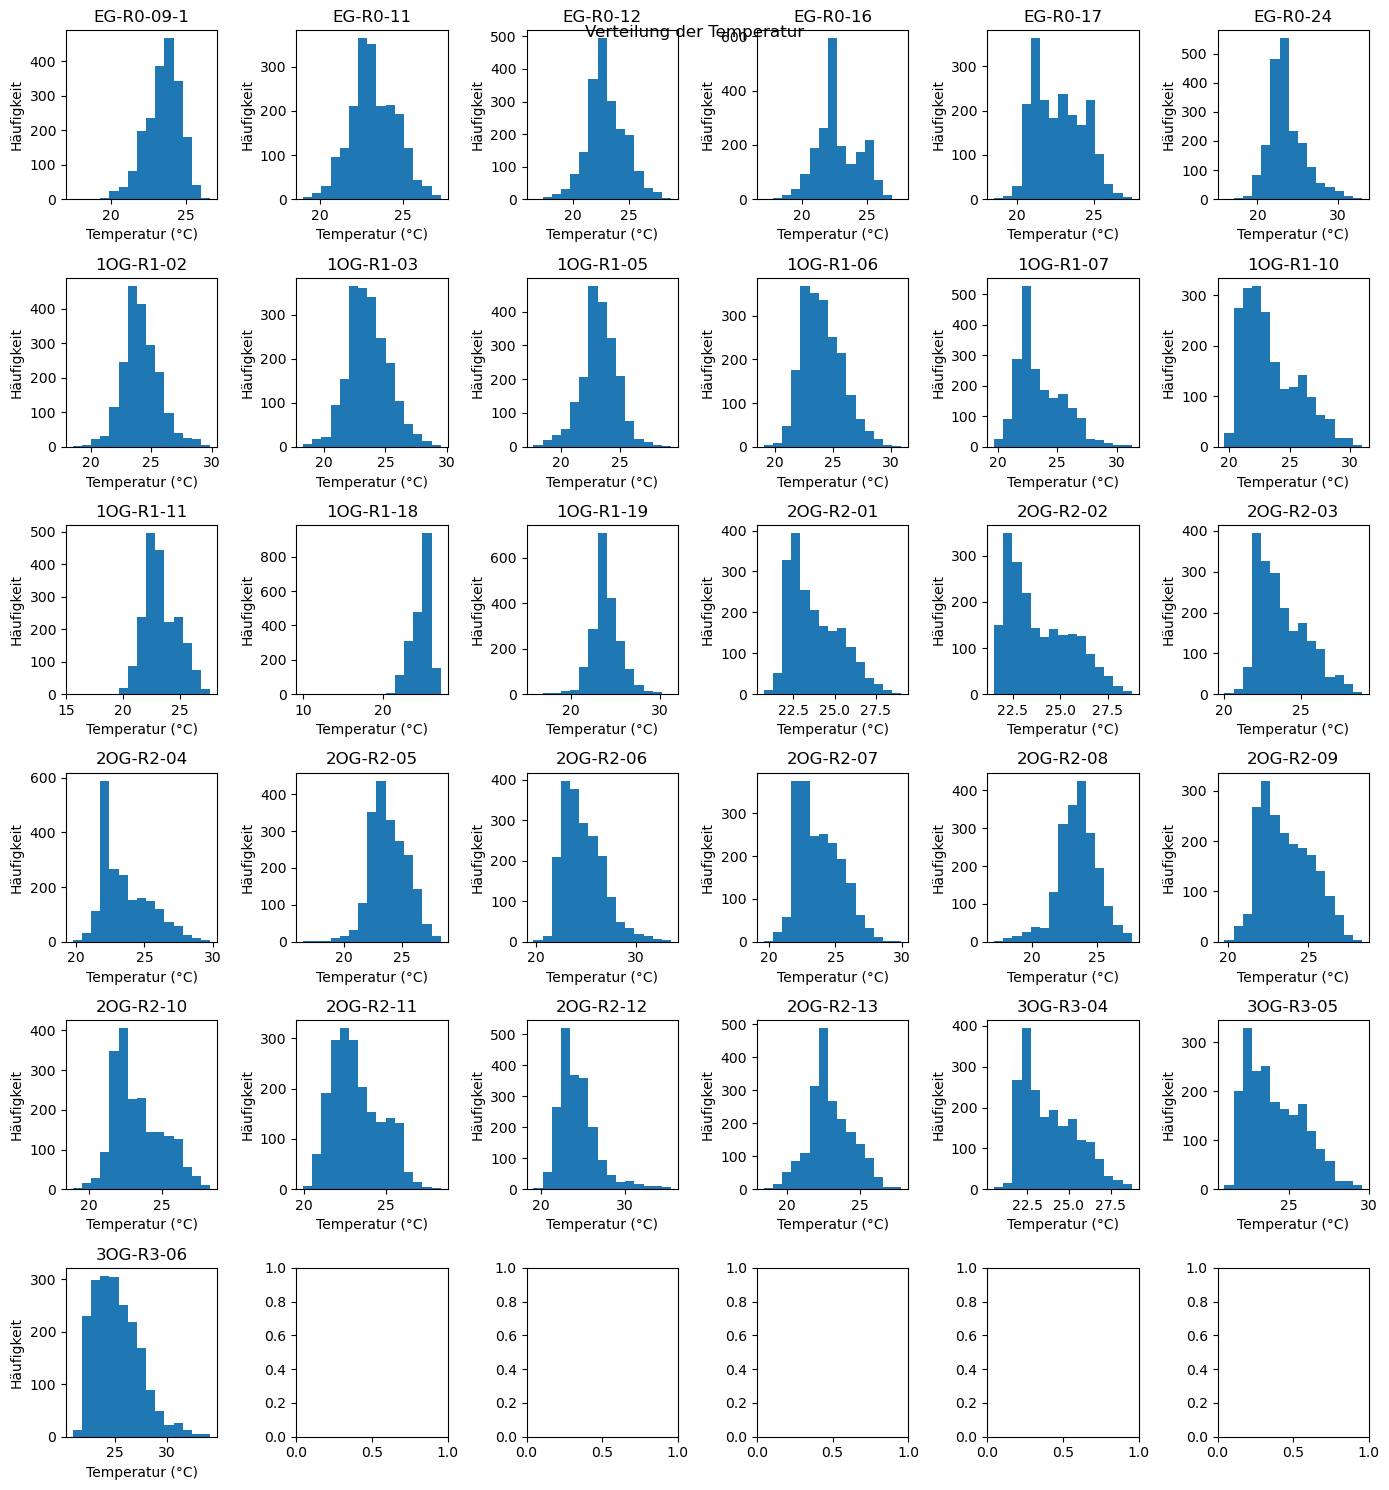

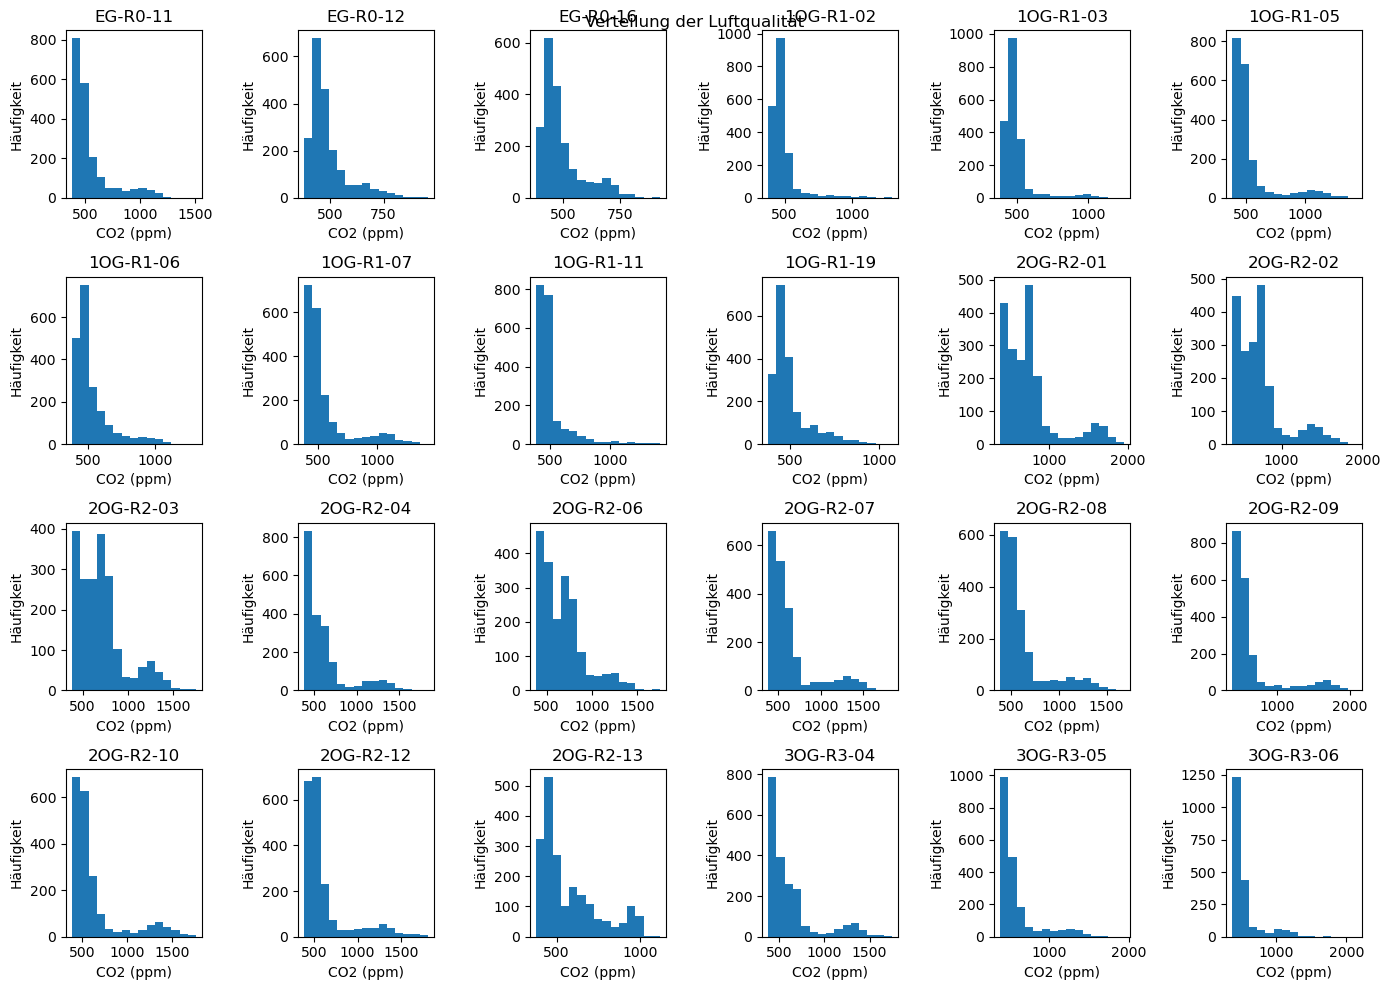

In [157]:
# Multiple Histograms

subfolders = ["Hist Qual/", "Hist Temp/"]
n_rows_list = [6, 4]

for rooms, names, title, xaxis, subfolder, n_rows in zip(rooms_data, names_list, titles, axes, subfolders, n_rows_list):
    fig, axs = plt.subplots(nrows=n_rows, ncols=6, figsize=(14, n_rows*2.5))
    for it, (room, name) in enumerate(zip(rooms, names)):
        current_row = int(it / 6)
        current_col = it % 6
        ax = axs[current_row, current_col]
        ax.hist(room, bins=15, label=name)
        ax.set_title(name)
        ax.set_xlabel(xaxis)
        ax.set_ylabel("Häufigkeit")

    plt.tight_layout()
    plt.suptitle("Verteilung der " + title)
    plt.savefig("../plots/distribution_plots/Histogram Subplots " + title + ".png")
    plt.show()

# Violin Plot

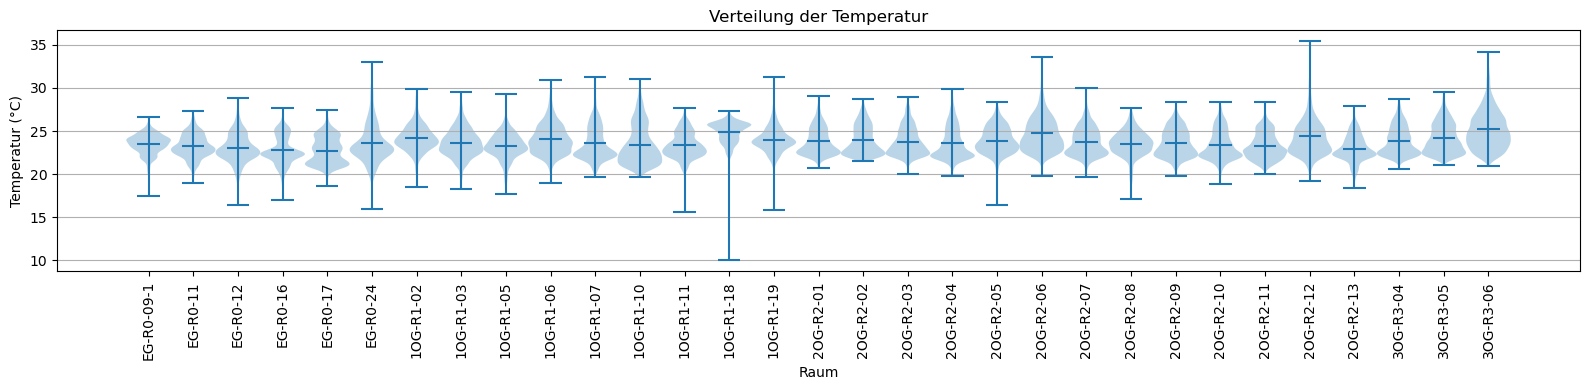

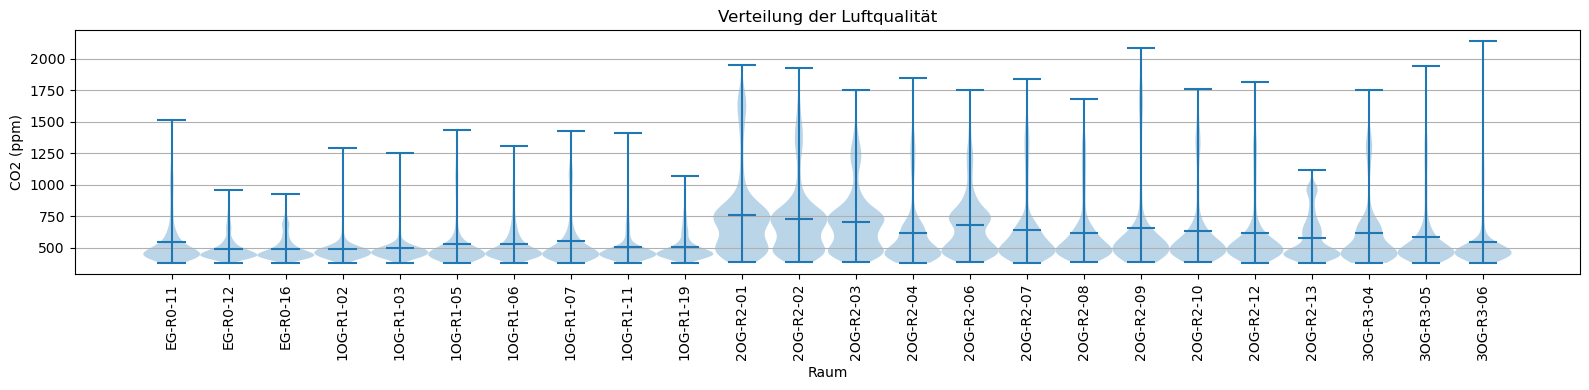

In [106]:
for rooms, names, title, yaxis in zip(
    [rooms_temp, rooms_qual],
    [names_temp, names_qual],
    ["Temperatur", "Luftqualität"],
    ['Temperatur (°C)', 'CO2 (ppm)']
    ):
    fig, ax = plt.subplots(figsize=(16, 4))

    ax.violinplot(rooms, widths=1, showmeans=True, showextrema=True)
    ax.set_title('Verteilung der ' + title)
    ax.set_xlabel('Raum')
    ax.set_ylabel(yaxis)
    ax.set_xticks(ticks=np.arange(1, len(rooms)+1), labels=names, rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()

    plt.savefig("../plots/distribution_plots/Distribution " + title + ".png")
    plt.show()

In [149]:
name

'EG-R0-09-1'